In [3]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))

In [4]:
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.metrics import recall_score, precision_score, roc_auc_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

import numpy as np

from src.utils.io_utils import load_model
from src.utils.logger import logger

### Import validation data

In [5]:
dataset = 'electronics'

In [7]:
val = pd.read_csv('../data/{}_edges_val.csv'.format(dataset))

In [8]:
val.head()

,product1,product2,edge
0,b0002xhbys,b000mx5xpm,1
1,b000hdjt4s,b00glzuxnc,1
2,b0026k9l3o,b00855b5qa,1
3,b00009wc1t,b003fxkxk6,1
4,b004rxkwi6,b0089syu9c,1


In [9]:
val['edge'].value_counts()

1    1321736
0    1321736
Name: edge, dtype: int64

### Import models

In [11]:
kv = KeyedVectors.load('../model/gensim-w2v-2019-12-05-0622.kv')

### Convert validation data to node IDs

In [12]:
def get_node_id(product_id):
    try:
        return node_dict[product_id]
    except KeyError:
        return '-1'

In [13]:
# val['product1_node_id'] = val['product1'].apply(get_node_id)
# val['product2_node_id'] = val['product2'].apply(get_node_id)

In [14]:
# val['products'] = list(zip(val['product1_node_id'], val['product2_node_id']))

In [15]:
val['products'] = list(zip(val['product1'], val['product2']))

### Get similarity scores

In [16]:
def get_kv_similarity(products):
    try:
        return kv.similarity(products[0], products[1])
    except KeyError:
        return -1
    
get_kv_sim_func = np.vectorize(get_kv_similarity)

In [17]:
%timeit val.head(100)['products'].apply(get_kv_similarity)

2.04 ms ± 30.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%timeit get_kv_sim_func(val.head(100)['products'].values)

1.73 ms ± 84 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
val['score'] = get_kv_sim_func(val['products'].values)

In [20]:
val['edge'].value_counts()

1    1321736
0    1321736
Name: edge, dtype: int64

In [21]:
val.head()

,product1,product2,edge,products,score
0,b0002xhbys,b000mx5xpm,1,"(b0002xhbys, b000mx5xpm)",0.865089
1,b000hdjt4s,b00glzuxnc,1,"(b000hdjt4s, b00glzuxnc)",0.815903
2,b0026k9l3o,b00855b5qa,1,"(b0026k9l3o, b00855b5qa)",0.981518
3,b00009wc1t,b003fxkxk6,1,"(b00009wc1t, b003fxkxk6)",0.801566
4,b004rxkwi6,b0089syu9c,1,"(b004rxkwi6, b0089syu9c)",0.972263


In [22]:
val.tail()

,product1,product2,edge,products,score
2643467,b00bwylgzq,b004i43mk4,0,"(b00bwylgzq, b004i43mk4)",-1.000000
2643468,b000v1pavw,b008hs1ypw,0,"(b000v1pavw, b008hs1ypw)",-0.008883
2643469,b006ifv0ku,b005ede8u6,0,"(b006ifv0ku, b005ede8u6)",-1.000000
2643470,b007wo2yj2,b00dvthjmo,0,"(b007wo2yj2, b00dvthjmo)",0.427947
2643471,b003v3c5z6,b00c68mzxe,0,"(b003v3c5z6, b00c68mzxe)",0.827514


In [23]:
# Set score of unseen item pairs to median score of seen item pairs
val_seen = val[val['score'] != -1]
median_score = np.median(val_seen['score'])
val['score'] = np.where(val['score'] == -1, median_score, val['score'])

### Evaluate results

In [24]:
roc_score = roc_auc_score(val['edge'], val['score'])
logger.info('AUC-ROC: {}'.format(roc_score))

2019-12-05 14:24:53,444 - AUC-ROC: 0.9082740832690214


In [25]:
roc_score_seen = roc_auc_score(val_seen['edge'], val_seen['score'])
logger.info('AUC-ROC: {}'.format(roc_score_seen))

2019-12-05 14:24:54,082 - AUC-ROC: 0.9736799488730573


Text(0.5, 1.0, 'Gensim Word2Vec - AUC-ROC: 0.9083')

/Users/eugeneyan/recsys/venv/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/eugeneyan/recsys/venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


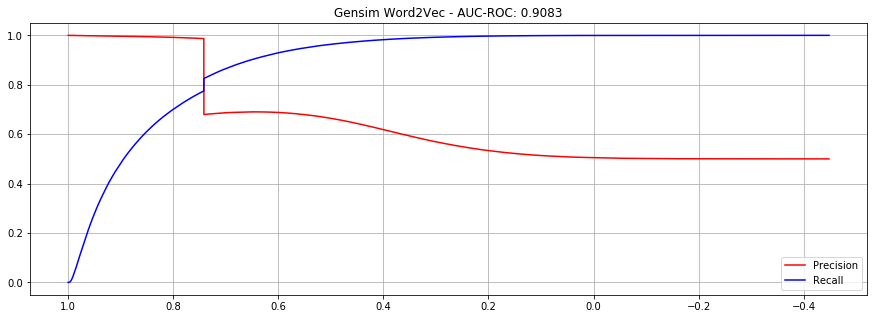

In [26]:
precision, recall, thresholds = precision_recall_curve(val['edge'], val['score'])
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(thresholds, precision[1:], color='r', label='Precision')
plt.plot(thresholds, recall[1:], color='b', label='Recall')
plt.gca().invert_xaxis()
plt.legend()
plt.title('Gensim Word2Vec - AUC-ROC: {:.4f}'.format(roc_score))

Text(0.5, 1.0, 'Gensim Word2Vec (seen items only) - AUC-ROC: 0.9737')

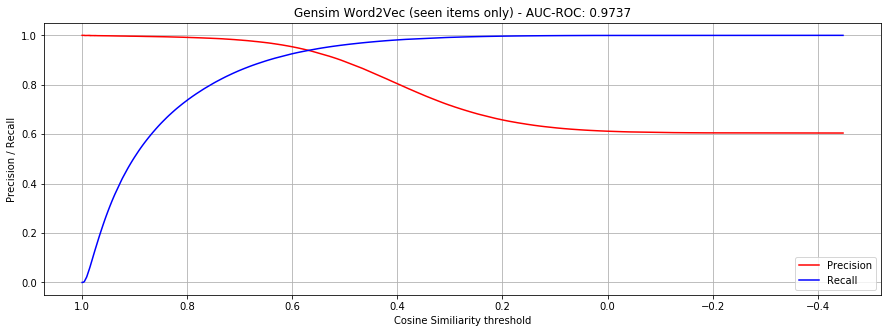

In [27]:
precision, recall, thresholds = precision_recall_curve(val_seen['edge'], val_seen['score'])
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(thresholds, precision[1:], color='r', label='Precision')
plt.plot(thresholds, recall[1:], color='b', label='Recall')
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('Cosine Similiarity threshold')
plt.ylabel('Precision / Recall')
plt.title('Gensim Word2Vec (seen items only) - AUC-ROC: {:.4f}'.format(roc_score_seen))

Text(0.5, 1.0, 'ROC curve')

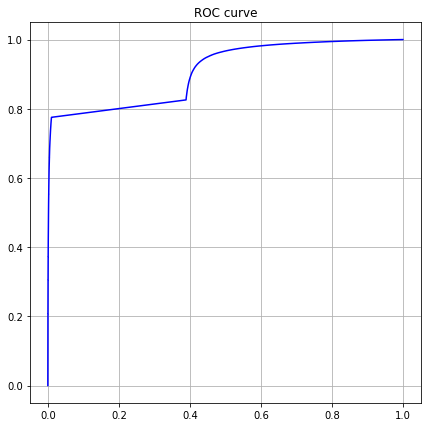

In [28]:
fpr, tpr, roc_thresholds = roc_curve(val['edge'], val['score'])
plt.figure(figsize=(7, 7))
plt.grid()
plt.plot(fpr, tpr, color='b')
plt.title('ROC curve')

Text(0.5, 1.0, 'Precision-Recall Trade-off')

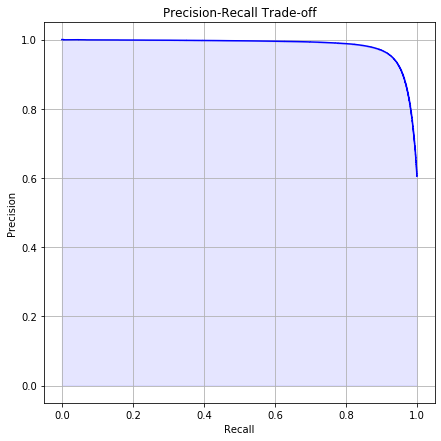

In [29]:
plt.figure(figsize=(7, 7))
plt.grid()
plt.step(recall, precision, color='b', label='Precision-Recall Trade-off')
plt.fill_between(recall, precision, alpha=0.1, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Trade-off')